In [93]:
import pandas as pd


excel_path = "./data/nomis_2025_05_04_010334.xlsx"

# Health categories
health_sheets = {
    "Very good health": 1,
    "Good health": 2,
    "Fair health": 3,
    "Bad health": 4,
    "Very bad health": 5,
}

# Columns to extract and rename to match 2021 format
nsec_column_map = {
    "1. Higher managerial, administrative and professional occupations":
        "L1, L2 and L3: Higher managerial, administrative and professional occupations",
    "2. Lower managerial, administrative and professional occupations":
        "L4, L5 and L6: Lower managerial, administrative and professional occupations",
    "3. Intermediate occupations": "L7: Intermediate occupations",
    "4. Small employers and own account workers": "L8 and L9: Small employers and own account workers",
    "5. Lower supervisory and technical occupations": "L10 and L11: Lower supervisory and technical occupations",
    "6. Semi-routine occupations": "L12: Semi-routine occupations",
    "7. Routine occupations": "L13: Routine occupations",
    "8. Never worked and long-term unemployed": "L14.1 and L14.2: Never worked and long-term unemployed",
    "L15 Full-time students": "L15: Full-time students",
    "Not classified": "Does not apply"
}


nsec_2021_map = {v: i + 1 for i, v in enumerate(nsec_column_map.values())}
nsec_2021_map["Does not apply"] = -8


all_frames = []

for sheet_name, health_code in health_sheets.items():
    df = pd.read_excel(excel_path, sheet_name=sheet_name, skiprows=8)

    df.rename(columns={
        df.columns[0]: "Lower tier local authorities",
        df.columns[1]: "Lower tier local authorities Code"
    }, inplace=True)

    selected_cols = ["Lower tier local authorities", "Lower tier local authorities Code"] + list(nsec_column_map.keys())
    df = df[selected_cols]

    df.rename(columns=nsec_column_map, inplace=True)

    df_long = df.melt(
        id_vars=["Lower tier local authorities", "Lower tier local authorities Code"],
        var_name="NS-SeC Category",
        value_name="Observation"
    )

    df_long["General health (6 categories)"] = sheet_name
    df_long["General health (6 categories) Code"] = health_code
    df_long["NS-SeC Code"] = df_long["NS-SeC Category"].map(nsec_2021_map)

    all_frames.append(df_long)


df_all_health = pd.concat(all_frames, ignore_index=True)

unique_lads = df_all_health["Lower tier local authorities Code"].unique()
lad_map = df_all_health.set_index("Lower tier local authorities Code")["Lower tier local authorities"].to_dict()
nsec_categories = df_all_health["NS-SeC Category"].unique()


placeholder_rows = []
for lad_code in unique_lads:
    lad_name = lad_map[lad_code]
    for nsec_cat in nsec_categories:
        placeholder_rows.append({
            "Lower tier local authorities": lad_name,
            "Lower tier local authorities Code": lad_code,
            "General health (6 categories)": "Does not apply",
            "General health (6 categories) Code": -8,
            "NS-SeC Category": nsec_cat,
            "NS-SeC Code": nsec_2021_map.get(nsec_cat, -8),
            "Observation": 0
        })


df_all_health = pd.concat([df_all_health, pd.DataFrame(placeholder_rows)], ignore_index=True)

# Renaming columns in 2011 dataset to match 2021 structure
df_2011_renamed = df_all_health.rename(columns={
    "Lower tier local authorities": "Lower tier local authorities",
    "Lower tier local authorities Code": "Lower tier local authorities Code",
    "General health (6 categories)": "General health (6 categories)",
    "General health (6 categories) Code": "General health (6 categories) Code",
    "NS-SeC Category": "National Statistics Socio-economic Classification (NS-SeC) (10 categories)",
    "NS-SeC Code": "National Statistics Socio-economic Classification (NS-SeC) (10 categories) Code",
    "Observation": "Observation"
})

# Reordering columns
final_column_order = [
    "Lower tier local authorities Code",
    "Lower tier local authorities",
    "General health (6 categories) Code",
    "General health (6 categories)",
    "National Statistics Socio-economic Classification (NS-SeC) (10 categories) Code",
    "National Statistics Socio-economic Classification (NS-SeC) (10 categories)",
    "Observation"
]

df_2011_final = df_2011_renamed[final_column_order]


df_2011_final = df_2011_final[~df_2011_final["Lower tier local authorities"].astype(str).str.contains("In order to protect against disclosure", na=False)]

# Remove rows with null or blank Local Authority Code
df_2011_final = df_2011_final[df_2011_final["Lower tier local authorities Code"].notna()]  
df_2011_final = df_2011_final[df_2011_final["Lower tier local authorities Code"].astype(str).str.strip() != ""]  


df_2011_final.reset_index(drop=True, inplace=True)
null_summary = df_2011_final.isnull().sum()
null_columns = null_summary[null_summary > 0]

if null_columns.empty:
    print("No null values found .")
else:
    print("Null values found:")
    print(null_columns)
missing = df_2011_final[df_2011_final["Lower tier local authorities Code"].isnull()]
print(missing.head())

# Exporting the final DataFrame to CSV
#df_2011_final.to_csv("./data/2011_NS_SEC_GeneralHealth.csv", index=False)
print("Data Exported.")


c:\Users\basav\anaconda3\envs\text_analytics\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\basav\anaconda3\envs\text_analytics\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\basav\anaconda3\envs\text_analytics\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\basav\anaconda3\envs\text_analytics\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


No null values found .
Empty DataFrame
Columns: [Lower tier local authorities Code, Lower tier local authorities, General health (6 categories) Code, General health (6 categories), National Statistics Socio-economic Classification (NS-SeC) (10 categories) Code, National Statistics Socio-economic Classification (NS-SeC) (10 categories), Observation]
Index: []
Data Exported.


c:\Users\basav\anaconda3\envs\text_analytics\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Checking for missing District codes

In [94]:
import pandas as pd

df_2011 = pd.read_csv("./2011_newModified.csv")
df_2021 = pd.read_csv("./data/NS-SEC_GeneralHealth.csv") 

# Extracting unique Local Authority codes

codes_2011 = set(df_2011["Lower tier local authorities Code"].dropna().astype(str).unique())
codes_2021 = set(df_2021["Lower tier local authorities Code"].dropna().astype(str).unique())

common_columns = set(df_2011.columns) & set(df_2021.columns)
missing_2011 = set(df_2021.columns) - set(df_2011.columns)
missing_2021 = set(df_2011.columns) - set(df_2021.columns)
print(f"Missing columns in 2021: {len(missing_2021)} → {sorted(missing_2021)}")
print(f" Missing columns in 2011: {len(missing_2011)} → {sorted(missing_2011)}")

missing_in_2021 = codes_2011 - codes_2021
missing_in_2011 = codes_2021 - codes_2011
common = codes_2011 & codes_2021


print(f" Common Local Authorities: {len(common)}")
print(f" Missing in 2021: {len(missing_in_2021)} → {sorted(missing_in_2021)}")
print(f" Missing in 2011: {len(missing_in_2011)} → {sorted(missing_in_2011)}")


Missing columns in 2021: 0 → []
 Missing columns in 2011: 0 → []
 Common Local Authorities: 323
 Missing in 2021: 25 → ['E06000028', 'E06000029', 'E07000004', 'E07000005', 'E07000006', 'E07000007', 'E07000048', 'E07000049', 'E07000050', 'E07000051', 'E07000052', 'E07000053', 'E07000150', 'E07000151', 'E07000152', 'E07000153', 'E07000154', 'E07000155', 'E07000156', 'E07000190', 'E07000191', 'E07000201', 'E07000204', 'E07000205', 'E07000206']
 Missing in 2011: 8 → ['E06000058', 'E06000059', 'E06000060', 'E06000061', 'E06000062', 'E07000244', 'E07000245', 'E07000246']


In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler


file_path = "./data/2011_NS_SEC_GeneralHealth.csv"
df = pd.read_csv(file_path)


# Pivoting the DataFrame to create a matrix of General Health categories vs NS-SeC categories
pivot_df = df.pivot_table(
    index='Lower tier local authorities',
    columns=['General health (6 categories)', 'National Statistics Socio-economic Classification (NS-SeC) (10 categories)'],
    values='Observation',
    aggfunc='sum',
    fill_value=0
)
#pivot_df.to_csv("./data/pca_pivot.csv", index=False)

# print(pivot_df.head())

# Standardizing the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pivot_df)

# Performing PCA 
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(pca_components, columns=['PCA1', 'PCA2'], index=pivot_df.index)
pca_df.reset_index(inplace=True)

# Performing t-SNE 
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_components = tsne.fit_transform(scaled_data)
tsne_df = pd.DataFrame(tsne_components, columns=['TSNE1', 'TSNE2'], index=pivot_df.index)
tsne_df.reset_index(inplace=True)

# Saving both projections to CSV
# pca_df.to_csv("./data/pca_projection.csv", index=False)
# tsne_df.to_csv("./data/tsne_projection.csv", index=False)

# Getting the feature loadings

# loadings = pd.DataFrame(
#     pca.components_.T,  
#     columns=['PCA1', 'PCA2'],
#     index=pivot_df.columns  # original features (health-category + class combinations)
# )

# pivot_df.columns = ['{} - {}'.format(h, c) for h, c in pivot_df.columns]


# print(loadings.sort_values(by='PC1', ascending=False))  
# print(loadings.sort_values(by='PCA2', ascending=False))  




c:\Users\basav\anaconda3\envs\text_analytics\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Processing Disablity Data

In [95]:
import pandas as pd


excel_path = "./data/nomis_2025_05_05_155322.xlsx"

disability_sheets = {
    "Day-to-day activities limited a": 1,
    "Sheet 1": 2,
    "Day-to-day activities not limit": 3
}


#Mapping NS-SeC columns to right format
nsec_column_map = {
    "1. Higher managerial, administrative and professional occupations":
        "L1, L2 and L3: Higher managerial, administrative and professional occupations",
    "2. Lower managerial, administrative and professional occupations":
        "L4, L5 and L6: Lower managerial, administrative and professional occupations",
    "3. Intermediate occupations": "L7: Intermediate occupations",
    "4. Small employers and own account workers": "L8 and L9: Small employers and own account workers",
    "5. Lower supervisory and technical occupations": "L10 and L11: Lower supervisory and technical occupations",
    "6. Semi-routine occupations": "L12: Semi-routine occupations",
    "7. Routine occupations": "L13: Routine occupations",
    "8. Never worked and long-term unemployed": "L14.1 and L14.2: Never worked and long-term unemployed",
    "L15 Full-time students": "L15: Full-time students",
    "Not classified": "Does not apply"
}


nsec_2021_map = {v: i + 1 for i, v in enumerate(nsec_column_map.values())}
nsec_2021_map["Does not apply"] = -8


all_frames = []


for sheet_name, disability_code in disability_sheets.items():
    df = pd.read_excel(excel_path, sheet_name=sheet_name, skiprows=9)

    
    df.columns = df.columns.str.strip().str.replace("\n", " ", regex=True)

    
    df.rename(columns={
        df.columns[0]: "Lower tier local authorities",
        df.columns[1]: "Lower tier local authorities Code"
    }, inplace=True)

    # Matching NS-SeC columns 
    matched_columns = {}
    for raw_col in df.columns[2:]:
        for expected, renamed in nsec_column_map.items():
            if expected.lower() in raw_col.lower():
                matched_columns[raw_col] = renamed
                break

    
    selected_cols = ["Lower tier local authorities", "Lower tier local authorities Code"] + list(matched_columns.keys())
    df = df[selected_cols]
    df.rename(columns=matched_columns, inplace=True)

    # Melt to long format
    df_long = df.melt(
        id_vars=["Lower tier local authorities", "Lower tier local authorities Code"],
        var_name="NS-SeC Category",
        value_name="Observation"
    )

    
    # Map to full descriptive label
    disability_label_map = {
        "Day-to-day activities limited a": "Disabled under the Equality Act: Day-to-day activities limited a lot",
        "Sheet 1": "Disabled under the Equality Act: Day-to-day activities limited a little",
        "Day-to-day activities not limit": "Not disabled under the Equality Act"
    }

    df_long["Disability - Equality act disabled (4 categories)"] = disability_label_map.get(sheet_name, sheet_name)

    
    df_long["Disability - Equality act disabled (4 categories) Code"] = disability_code
    df_long["NS-SeC Code"] = df_long["NS-SeC Category"].map(nsec_2021_map)

    all_frames.append(df_long)


df_all_disability = pd.concat(all_frames, ignore_index=True)


unique_lads = df_all_disability["Lower tier local authorities Code"].unique()
lad_map = df_all_disability.set_index("Lower tier local authorities Code")["Lower tier local authorities"].to_dict()
nsec_categories = df_all_disability["NS-SeC Category"].unique()

placeholder_rows = []
for lad_code in unique_lads:
    lad_name = lad_map[lad_code]
    for nsec_cat in nsec_categories:
        placeholder_rows.append({
            "Lower tier local authorities": lad_name,
            "Lower tier local authorities Code": lad_code,
            "Disability - Equality act disabled (4 categories)": "Does not apply",
            "Disability - Equality act disabled (4 categories) Code": -8,
            "NS-SeC Category": nsec_cat,
            "NS-SeC Code": nsec_2021_map.get(nsec_cat, -8),
            "Observation": 0
        })

# Appending structural rows
df_all_disability = pd.concat([df_all_disability, pd.DataFrame(placeholder_rows)], ignore_index=True)

# Renaming to match column format
df_renamed = df_all_disability.rename(columns={
    "NS-SeC Category": "National Statistics Socio-economic Classification (NS-SeC) (10 categories)",
    "NS-SeC Code": "National Statistics Socio-economic Classification (NS-SeC) (10 categories) Code"
})

# Reordering final columns
final_columns = [
    "Lower tier local authorities Code",
    "Lower tier local authorities",
    "Disability - Equality act disabled (4 categories) Code",
    "Disability - Equality act disabled (4 categories)",
    "National Statistics Socio-economic Classification (NS-SeC) (10 categories) Code",
    "National Statistics Socio-economic Classification (NS-SeC) (10 categories)",
    "Observation"
]
df_final = df_renamed[final_columns]


df_final = df_final[~df_final["Lower tier local authorities"].astype(str).str.contains("In order to protect", na=False)]
df_final = df_final[df_final["Lower tier local authorities Code"].notna()]
df_final = df_final[df_final["Lower tier local authorities Code"].astype(str).str.strip() != ""]


df_final.reset_index(drop=True, inplace=True)


null_summary = df_final.isnull().sum()
null_columns = null_summary[null_summary > 0]

if null_columns.empty:
    print("No null values found.")
else:
    print("Null values found:")
    print(null_columns)

# Final export
#df_final.to_csv("./data/2011_NS_SEC_Disability.csv", index=False)
print("Exported to CSV")


c:\Users\basav\anaconda3\envs\text_analytics\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\basav\anaconda3\envs\text_analytics\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\basav\anaconda3\envs\text_analytics\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


No null values found.
Exported to CSV


Saved clustered t-SNE results to CSV


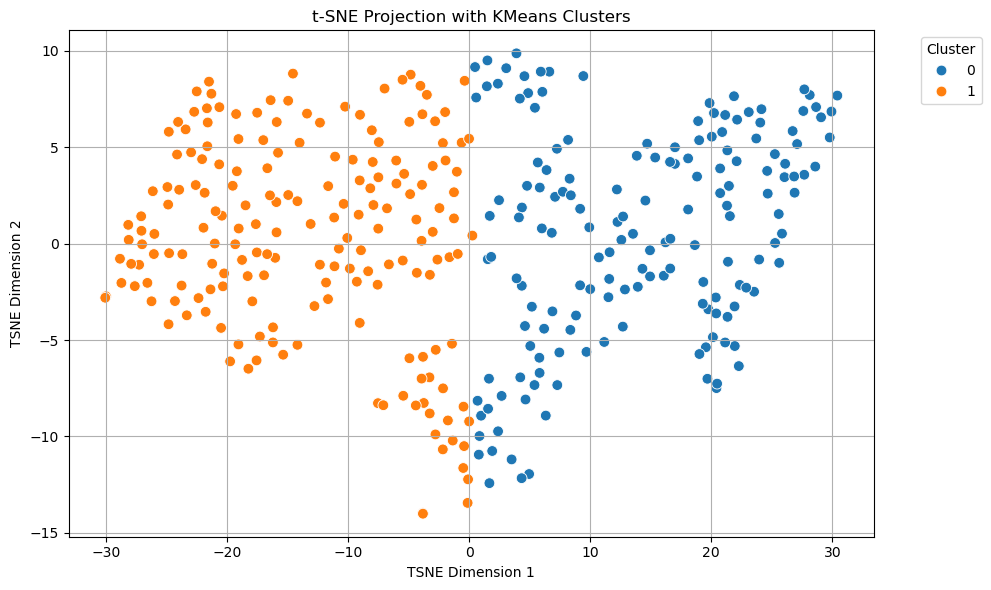

In [97]:
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Load your pivoted dataframe (e.g. health × NS-SeC or disability × NS-SeC)
df = pd.read_csv("./data/2011_NS_SEC_Disability.csv")

# Pivot: all disability × class combinations become columns
pivot_df = df.pivot_table(
    index='Lower tier local authorities',
    columns=['Disability - Equality act disabled (4 categories)', 
             'National Statistics Socio-economic Classification (NS-SeC) (10 categories)'],
    values='Observation',
    aggfunc='sum',
    fill_value=0
)

# Standardize
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pivot_df)

# Optional: PCA first for smoother t-SNE
pca = PCA(n_components=10)  # keep top 10 PCs
pca_data = pca.fit_transform(scaled_data)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_data = tsne.fit_transform(pca_data)

# Run KMeans on PCA or t-SNE data (t-SNE usually better for visualization, PCA better for structure)
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(tsne_data)

# Prepare result DataFrame
tsne_df = pd.DataFrame(tsne_data, columns=["TSNE1", "TSNE2"])
tsne_df["Lower tier local authorities"] = pivot_df.index
tsne_df["Cluster"] = clusters

# Save to CSV
#tsne_df.to_csv("tsne_disability_with_clusters.csv", index=False)
print("Saved clustered t-SNE results to CSV")

plt.figure(figsize=(10, 6))
sns.scatterplot(data=tsne_df, x="TSNE1", y="TSNE2", hue="Cluster", palette="tab10", s=60)
plt.title("t-SNE Projection with KMeans Clusters")
plt.xlabel("TSNE Dimension 1")
plt.ylabel("TSNE Dimension 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.grid(True)
plt.show()

# Store results
# tsne_df = pd.DataFrame(X_embedded, columns=["TSNE_1", "TSNE_2"])
# tsne_df["Lower tier local authorities"] = wide_df.index


K = 2 -> Silhouette Score: 0.599
K = 3 -> Silhouette Score: 0.530
K = 4 -> Silhouette Score: 0.389
K = 5 -> Silhouette Score: 0.300
K = 6 -> Silhouette Score: 0.253
K = 7 -> Silhouette Score: 0.284
K = 8 -> Silhouette Score: 0.268
K = 9 -> Silhouette Score: 0.269
K = 10 -> Silhouette Score: 0.242


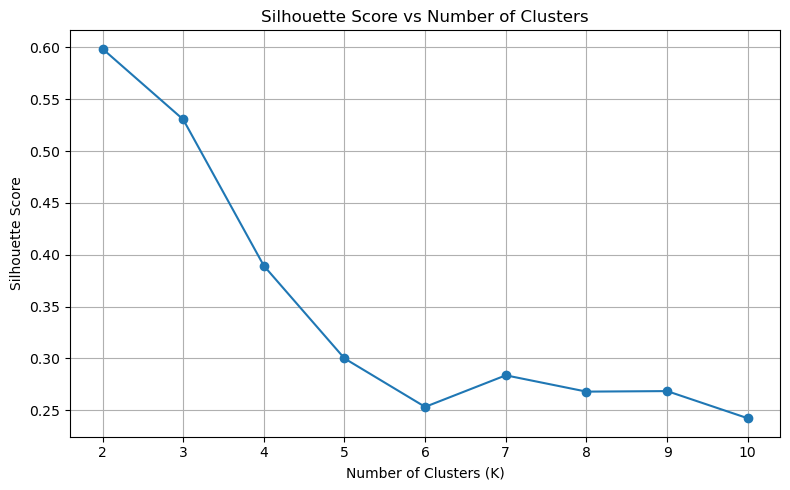

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


df = pd.read_csv("./data/2011_NS_SEC_Disability.csv")


pivot_df = df.pivot_table(
    index="Lower tier local authorities",
    columns=["Disability - Equality act disabled (4 categories)",
             "National Statistics Socio-economic Classification (NS-SeC) (10 categories)"],
    values="Observation",
    aggfunc="sum",
    fill_value=0
)

# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(pivot_df)


silhouette_scores = {}
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores[k] = score
    print(f"K = {k} -> Silhouette Score: {score:.3f}")

# Plotting the silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker='o')
plt.title("Silhouette Score vs Number of Clusters")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.tight_layout()
plt.show()


Using 2 clusters according to silhouette score

Calculating Bayesian Credible Intervals

In [99]:
import pandas as pd
import numpy as np


df = pd.read_csv("./data/2011_NS_SEC_Disability.csv")

# Filtering by disability category
target_category = "Disabled under the Equality Act: Day-to-day activities limited a lot"
df = df[df["Disability - Equality act disabled (4 categories)"] == target_category]


results = []

# For each district, calculating the Dirichlet posterior
for district in df["Lower tier local authorities"].unique():
    sub = df[df["Lower tier local authorities"] == district]
    
    counts = sub.groupby("National Statistics Socio-economic Classification (NS-SeC) (10 categories)")["Observation"].sum().sort_index()
    
    # Filling missing categories with 0
    all_classes = df["National Statistics Socio-economic Classification (NS-SeC) (10 categories)"].unique()
    counts = counts.reindex(sorted(all_classes), fill_value=0)
    
    alpha = counts.values + 1  # add-1 smoothing
    samples = np.random.dirichlet(alpha, size=5000)
    
    for i, cls in enumerate(counts.index):
        results.append({
            "District": district,
            "NS-SeC Class": cls,
            "Mean": samples[:, i].mean(),
            "Lower": np.percentile(samples[:, i], 2.5),
            "Upper": np.percentile(samples[:, i], 97.5)
        })


#pd.DataFrame(results).to_csv("./data/Bayesian_credible_intervals_forDisability.csv", index=False)
print("Saved to CSV")


Saved to CSV


In [ ]:
import pandas as pd


data_2011_path = '/./data/2011_NS_SEC_GeneralHealth.csv'
data_2021_path = '/./data/NS-SEC_GeneralHealth.csv'


df_2011 = pd.read_csv(data_2011_path)
df_2021 = pd.read_csv(data_2021_path)


df_2011['Year'] = 2011
df_2021['Year'] = 2021


df_2011 = df_2011.rename(columns={
    "General health (6 categories)": "General health (6 categories)",
    "Lower tier local authorities": "Lower tier local authorities",
    "Observation": "Observation"
})

df_2021 = df_2021.rename(columns={
    "General health (6 categories)": "General health (6 categories)",
    "Lower tier local authorities": "Lower tier local authorities",
    "Observation": "Observation"
})


columns = ["Year", "Lower tier local authorities", "General health (6 categories)", "Observation"]


df_combined = pd.concat([df_2011[columns], df_2021[columns]], ignore_index=True)


df_combined['Observation'] = df_combined['Observation'].fillna(0)


output_path = "/mnt/data/general_health_trend_by_district.csv"
#df_combined.to_csv(output_path, index=False)

print(f"Data successfully saved")
